# Stroke Prediction Using Decision Tree

In this notebook, we will be implementing a decision tree to predict the likelihood of a stroke. There are several interesting variables that we will be using to predict the likelihood of a stroke in a patient. Here are the variables:

Age: Older individuals might be more prone to strokes.

Hypertension: Individuals with hypertension are often at a higher risk of experiencing a stroke.

Heart Disease: Existing heart diseases can be a strong predictor of stroke.

Average Glucose Level: High glucose levels might be linked with an increased risk of stroke.

BMI (Body Mass Index): A higher BMI might be associated with a greater risk of stroke.

Smoking Status: Smoking is often associated with a range of health issues, including a higher risk of stroke

# Table of Contents
1. [Import Libraries](#section1)
2. [Load the Dataset](#section2)
3. [Preliminary Data Analysis](#section3)
    - [Initial Data Overview](#section3.1)
    - [Summary Statistics](#section3.2)
4. [Exploring the Data](#section4)
    - [Interpretation of Data](#section4.1)
    - [Plotting variation](#section4.2)
5. [Preparing the Data](#section5)
    - [Imbalanced Dataset](#section5.1)
6. [Feature Selection and Analysis](#section6)
7. [Implementing Decision Tree algorithm](#section7)
8. [Optimization and Hyper-parameter Tuning](#section8)

## <a id='section1'></a>
## Section 1: Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier

<a id='section2'></a>
## Section 2: Load the Dataset

* load data from csv format into a pandas dataframe

In [2]:
data = pd.read_csv("C:/Users/CAU Student/Downloads/healthcare-dataset-stroke-data.csv")

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


<a id='section3'></a>
## Section 3: Preliminary Data Analysis

* Checking the data and that all columns are present in the dataset
* Verifying that there are no duplicate ID numbers in dataset
* Inspecting for missing values (N/A)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
# List of required columns
required_columns = [
    'id', 'gender', 'age', 'hypertension', 'heart_disease', 
    'ever_married', 'work_type', 'Residence_type', 
    'avg_glucose_level', 'bmi', 'smoking_status', 'stroke'
]

# Check if all required columns are present in the DataFrame
if set(required_columns).issubset(data.columns):
    print("All required columns are present.")
else:
    missing_columns = set(required_columns) - set(data.columns)
    print(f"The following required columns are missing: {', '.join(missing_columns)}")

All required columns are present.


In [7]:
# Check for duplicate rows in the dataset
duplicate_rows = data.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Removing any duplicate rows if there are any
if duplicate_rows.any():
    data = data.drop_duplicates()
    print("Duplicate rows have been dropped.")
else:
    print("No duplicate rows found.")

Number of duplicate rows: 0
No duplicate rows found.


In [8]:
# Checking again that all columns are present and are accounted for 
missing_columns = [col for col in required_columns if col not in data.columns]

# Conditional test to ensure all columns are going to be included for model testing
if not missing_columns:
    print("All required columns are present!")
    print("\n")
else:
    print(f"Missing columns: {', '.join(missing_columns)}")
    print("\n")
    breakpoint

All required columns are present!




In [10]:
#Checking for Missing Values
missing_values = data.isna().sum()
print("Number of missing values for each column:")
print(missing_values)

Number of missing values for each column:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [12]:
# Handling missing values in the 'bmi' column
# Strategy: Replacing missing values with the mean
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

# Verify the number of missing values in the 'bmi' column after handling them
print(f"Missing values in 'bmi' after handling: {data['bmi'].isna().sum()}")

Missing values in 'bmi' after handling: 0


<a id='section3.1'></a>
### Section 3.1: Initial Data Overview

* Summary of the dataset
* Statistical summary for the numerical columns
* Data Integrity - Second Test and Results

In [13]:
# Displaying the first five rows
print(data.head())
print("\n")

# Summary statistics for the numerical columns
print("Summary statistics for the numerical columns : ")
display(data.describe())

# *** RUN 2: Displaying dimensions of dataframe ***
print("The dataframe has", data.shape[0], "rows and", data.shape[1], "columns, \n")

# *** RUN 2: Checking for duplicates ***
print("Number of duplicate data : ",data.duplicated().sum())
print("\n")

# *** RUN2: Checking for missing values ***
print("Number of missing values for each feature column : \n", data.isna().sum())
print("\n")


      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level        bmi  \
0        Private          Urban             228.69  36.600000   
1  Self-employed          Rural             202.21  28.893237   
2        Private          Rural             105.92  32.500000   
3        Private          Urban             171.23  34.400000   
4  Self-employed          Rural             174.12  24.000000   

    smoking_status  stroke  
0  formerly smoked       1  
1     never smoked       1  
2     never smoked       1  
3           smokes       1  
4     never smoked       1  


Summary statistics for t

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The dataframe has 5110 rows and 12 columns, 

Number of duplicate data :  0


Number of missing values for each feature column : 
 id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64




<a id='section4'></a>
## 4. Exploring the Data

* Plot distributions of columns
* Exploring descriptive statistics and visualizations of individual variables
* Plotting variation of all independent variables vs diagnosis


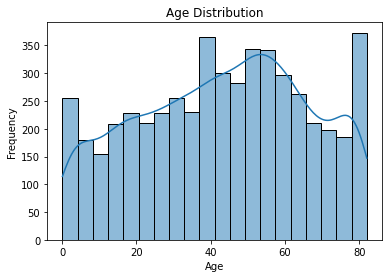

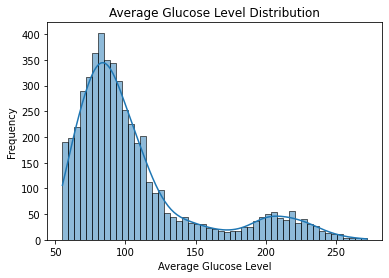

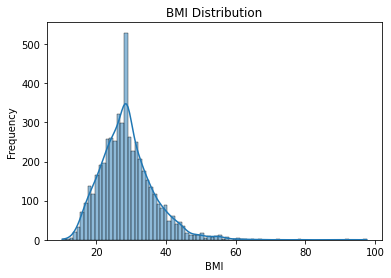

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


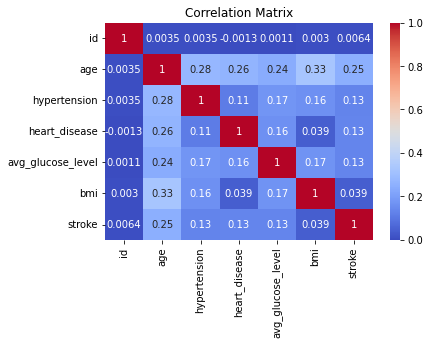

In [15]:
# Plot the distribution of the 'age' column
plt.figure()
sns.histplot(data['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of the 'avg_glucose_level' column
plt.figure()
sns.histplot(data['avg_glucose_level'], kde=True)
plt.title('Average Glucose Level Distribution')
plt.xlabel('Average Glucose Level')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of the 'bmi' column
plt.figure()
sns.histplot(data['bmi'], kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

# Display the count of each unique value in the 'gender' column
print(data['gender'].value_counts())

# Display the count of each unique value in the 'smoking_status' column
print(data['smoking_status'].value_counts())

# Display the correlation matrix
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

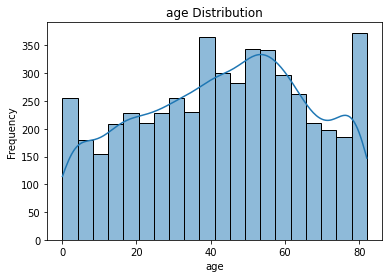

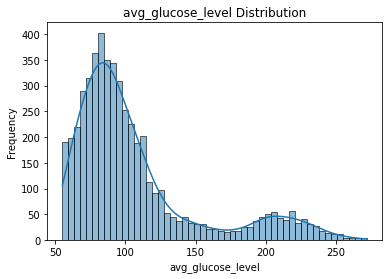

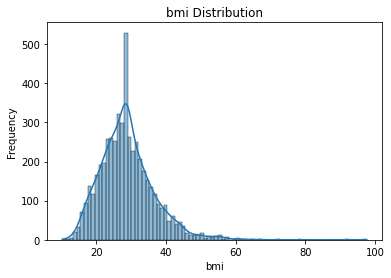

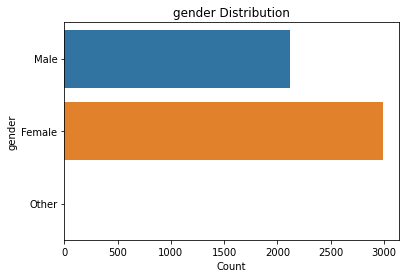

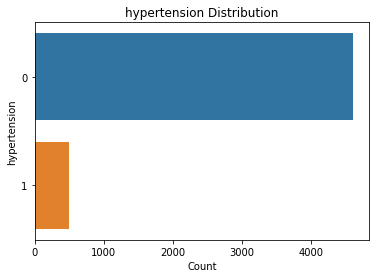

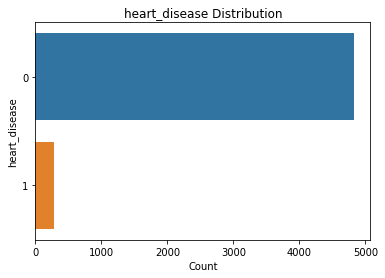

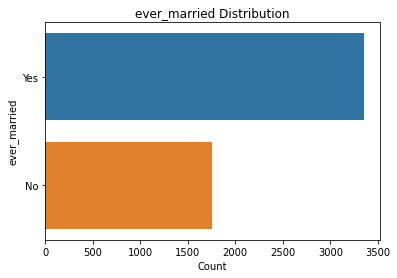

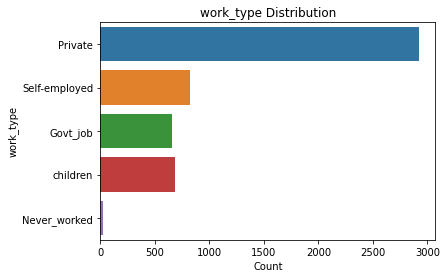

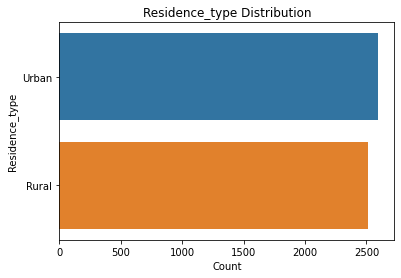

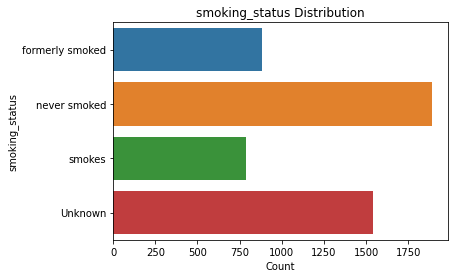

In [16]:
# Plotting distributions of numeric columns
for column in ['age', 'avg_glucose_level', 'bmi']:
    plt.figure()
    sns.histplot(data[column], kde=True)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Plotting distributions of categorical columns
for column in ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    plt.figure()
    sns.countplot(y=data[column])
    plt.title(f'{column} Distribution')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()

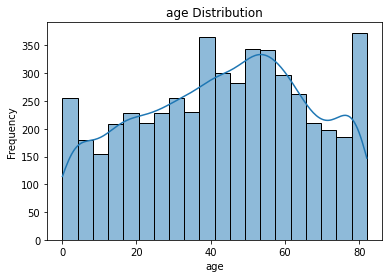

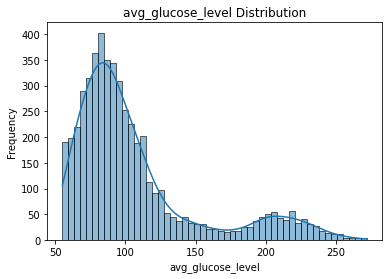

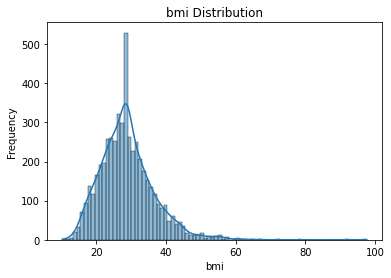

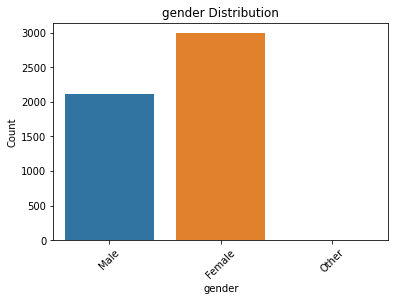

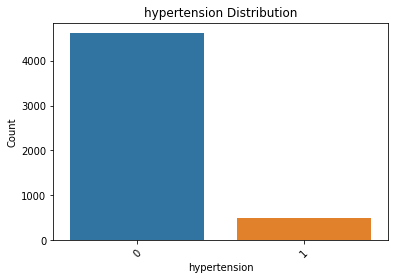

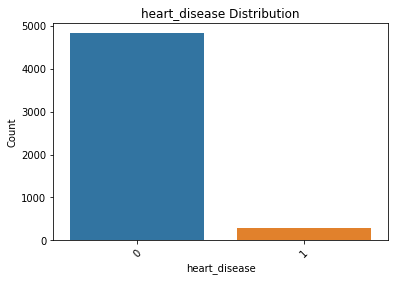

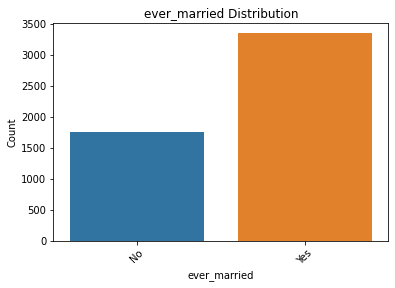

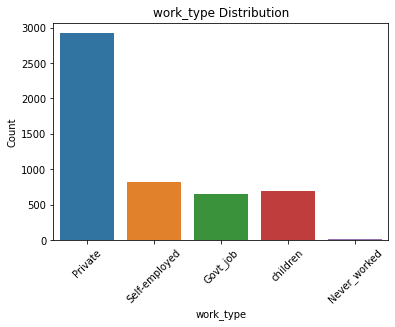

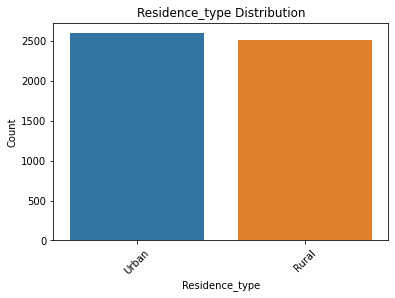

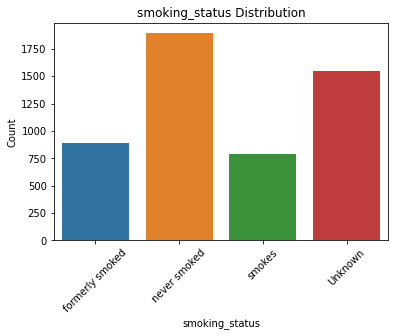

In [21]:
# Impute missing values for continuous columns with the mean
for col in ['age', 'avg_glucose_level', 'bmi']:
    data[col].fillna(data[col].mean(), inplace=True)

# Impute missing values for categorical columns with the mode
for col in ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Convert binary variables to the correct data type
data['hypertension'] = data['hypertension'].astype('category')
data['heart_disease'] = data['heart_disease'].astype('category')
data['ever_married'] = data['ever_married'].astype('category')

# List of continuous and categorical columns
continuous_columns = ['age', 'avg_glucose_level', 'bmi']
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                       'work_type', 'Residence_type', 'smoking_status']

# Plotting histograms for continuous columns
for col in continuous_columns:
    plt.figure()
    sns.histplot(data[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Plotting bar plots for categorical columns
for col in categorical_columns:
    plt.figure()
    sns.countplot(x=data[col])
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

               age  avg_glucose_level          bmi
count  5110.000000        5110.000000  5110.000000
mean     43.226614         106.147677    28.893237
std      22.612647          45.283560     7.698018
min       0.080000          55.120000    10.300000
25%      25.000000          77.245000    23.800000
50%      45.000000          91.885000    28.400000
75%      61.000000         114.090000    32.800000
max      82.000000         271.740000    97.600000


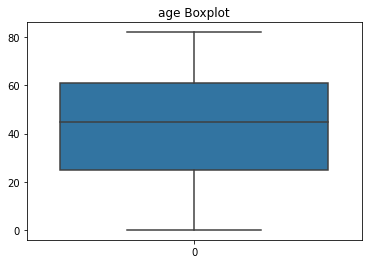

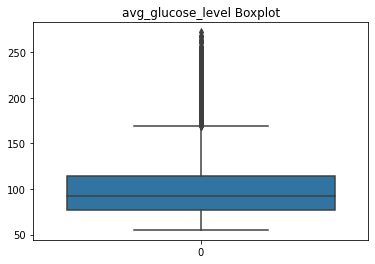

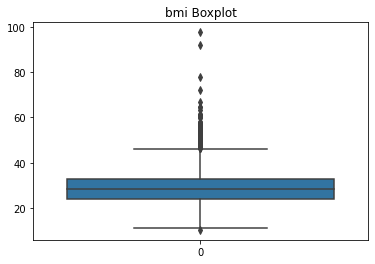

In [22]:
# Display the statistical summary for continuous variables
print(data[continuous_columns].describe())

# Boxplots for continuous columns
for col in continuous_columns:
    plt.figure()
    sns.boxplot(data[col])
    plt.title(f'{col} Boxplot')
    plt.show()

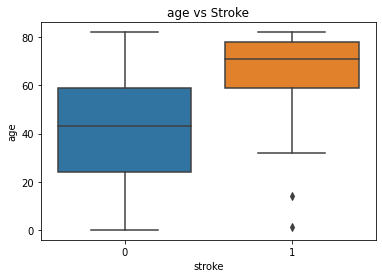

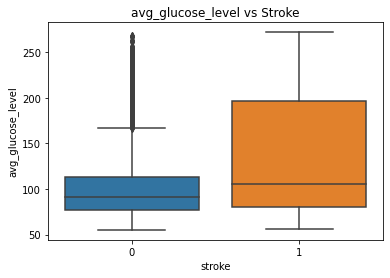

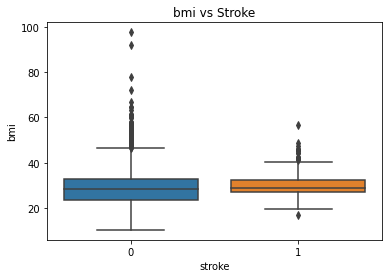

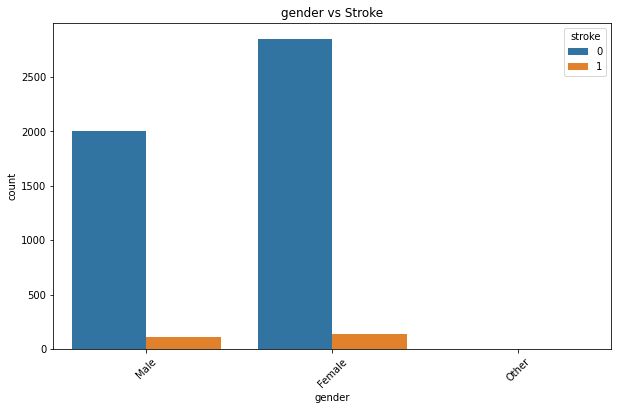

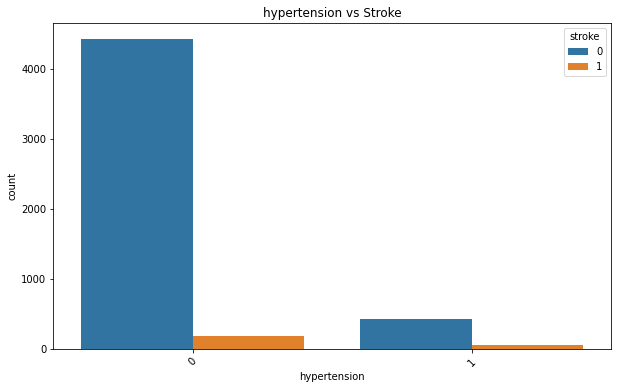

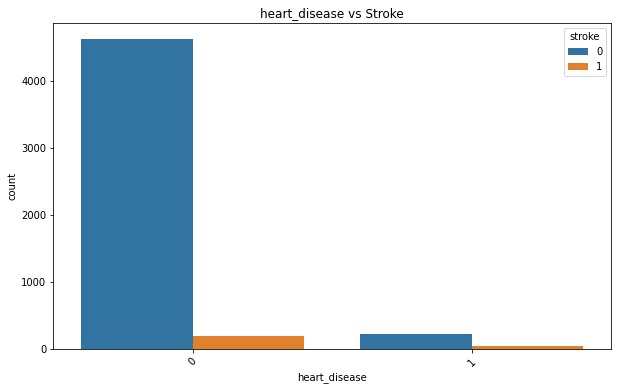

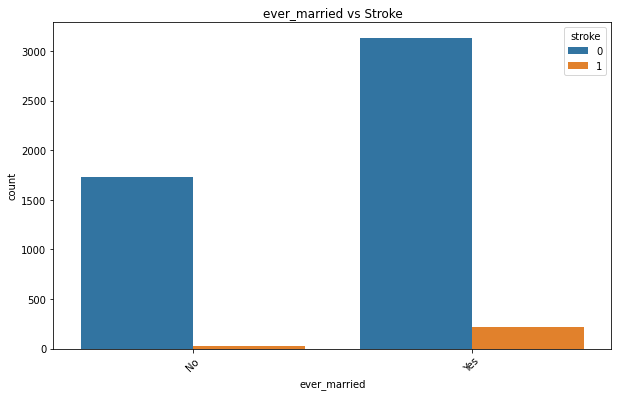

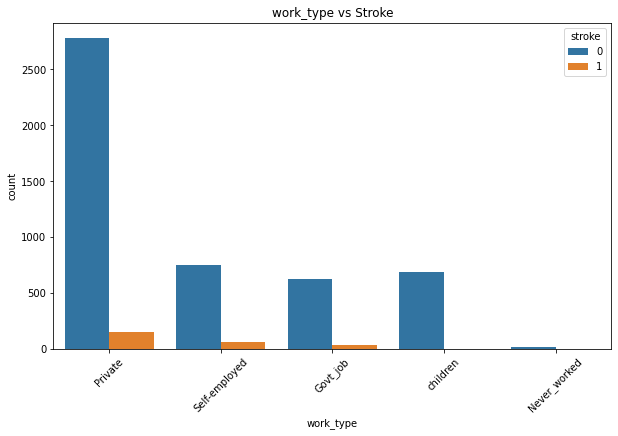

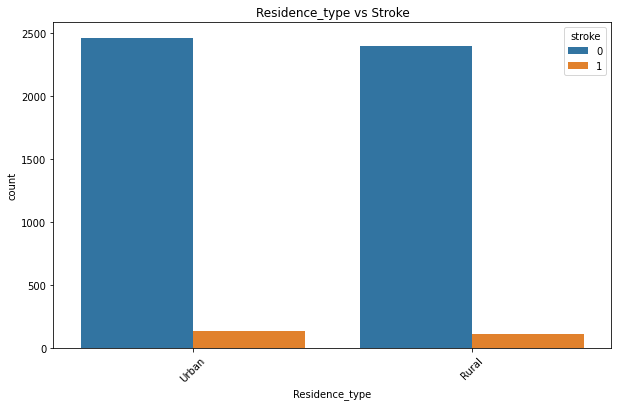

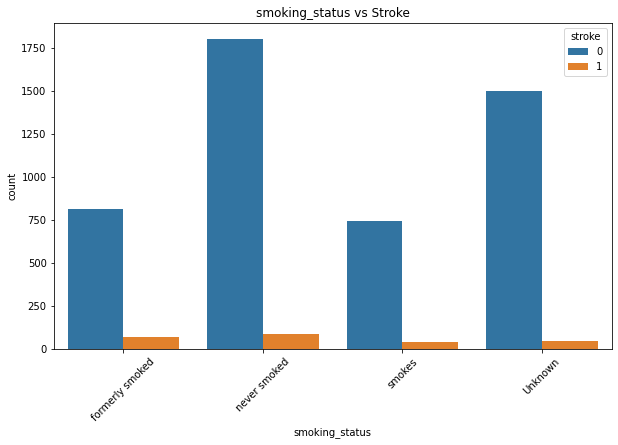

In [23]:
# Boxplots for continuous columns vs diagnosis
for col in continuous_columns:
    plt.figure()
    sns.boxplot(x='stroke', y=col, data=data)
    plt.title(f'{col} vs Stroke')
    plt.show()

# Bar plots for categorical columns vs diagnosis
for col in categorical_columns:
    plt.figure(figsize=(10,6))
    sns.countplot(x=col, hue='stroke', data=data)
    plt.title(f'{col} vs Stroke')
    plt.xticks(rotation=45)
    plt.show()

<a id='#section4.1'></a>
### Interpretation of Data

### 1. Distributions of Columns:
Age: If the histogram reveals a relatively even spread of ages, it suggests that the dataset includes individuals from various age groups. A skew to the right may imply more younger individuals, while a skew to the left indicates more elderly individuals. The presence of any age clusters could also suggest specific age groups that might be at a higher risk for strokes.

Average Glucose Level: The ideal distribution would be a bell curve centered around a typical blood glucose level. A significant right skew might indicate many individuals with higher glucose levels, which could be a potential risk factor for strokes.

BMI: A bell-curve-shaped distribution around a median BMI value would be expected. Extremely high or low values would indicate the presence of outliers.

Categorical Variables: Bar plots for categorical columns like gender, hypertension, heart_disease, etc., would reveal the distribution of each category. For instance, if hypertension shows more people with hypertension, that could be an indicator of the prevalence of this condition in the dataset.

### 2. Descriptive Statistics and Visualizations:
Boxplots can be instrumental in identifying outliers. For instance, outliers in the bmi boxplot could highlight individuals with extremely high or low BMIs, which might need further investigation.

The descriptive statistics provide a numerical summary. For continuous variables, mean and median values give central tendencies, while the standard deviation provides variability. Min and max values show the range of the data.

### 3. Variation of All Independent Variables vs Diagnosis:
Boxplots comparing variables like age, avg_glucose_level, and bmi against stroke will reveal differences in medians between those who had a stroke and those who didn't. For instance, a higher median age for stroke-positive individuals might suggest that older individuals are more at risk.

For categorical variables, the count plots would reveal which categories are more prevalent in stroke-positive cases. For example, if more stroke-positive individuals are observed in the "smoker" category of smoking_status, it could indicate a potential correlation between smoking and stroke occurrence.

<a id='section5'></a>
## Section 5: Preparing the Data

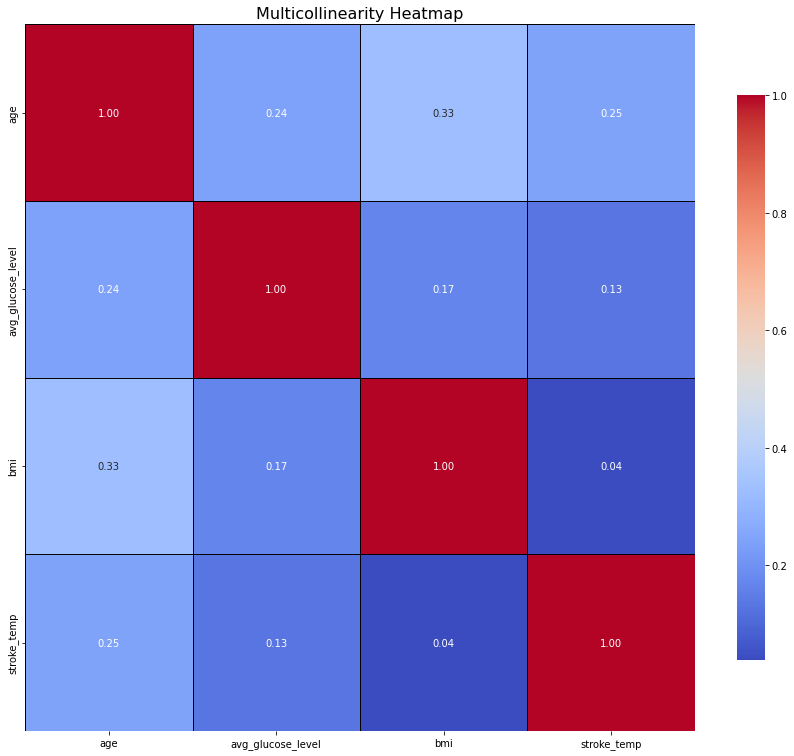

Count of each stroke category:
Stroke: 249
No-Stroke: 4861


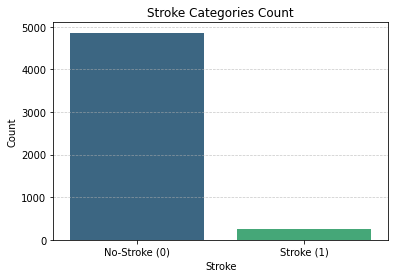

In [24]:
# Create a copy of the original dataset
prepared_data = data.copy()

# Drop the 'id' column as it is not a feature
prepared_data.drop('id', axis=1, inplace=True)

# Handle missing values 
for col in ['age', 'avg_glucose_level', 'bmi']:
    prepared_data[col].fillna(prepared_data[col].mean(), inplace=True)

for col in ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    prepared_data[col].fillna(prepared_data[col].mode()[0], inplace=True)

# Temporarily convert the 'stroke' column to numerical values for correlation analysis
stroke_mapping = {1: 1, 0: 0}
prepared_data['stroke_temp'] = prepared_data['stroke'].replace(stroke_mapping)

# Create a correlation matrix using the temporary numerical 'stroke' column
plt.figure(figsize=[15, 13])
corr_matrix = prepared_data.drop('stroke', axis=1).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=1, linecolor='black', cbar=True, cbar_kws={"shrink": .8})
plt.title('Multicollinearity Heatmap', fontsize=16)
plt.show()

# Drop the temporary numerical 'stroke' column, keeping the original 'stroke' column with 1 and 0 labels
prepared_data.drop('stroke_temp', axis=1, inplace=True)

# Checking the balance of the classifications in the 'stroke' column
stroke_count = prepared_data['stroke'].value_counts()
print(f"Count of each stroke category:\nStroke: {stroke_count[1]}\nNo-Stroke: {stroke_count[0]}")

# Visual representation of the balance in the 'stroke' column
plt.figure(figsize=(6, 4))
sns.barplot(x=stroke_count.index, y=stroke_count.values, palette='viridis')
plt.title('Stroke Categories Count')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No-Stroke (0)', 'Stroke (1)'])  # Setting custom labels for the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.7)
plt.show()

### Explanation :
* The id column is dropped as it does not contribute to the analysis.
* Missing values in continuous columns are imputed with the mean, and in categorical columns with the mode.
* A temporary column stroke_temp is created to hold the numerical representations of the 'stroke' column.
* A heatmap of the correlation matrix is plotted to visualize the correlation between different features and the temporary 'stroke' variable.
* The balance of the classes in the 'stroke' column is displayed both numerically and through a bar plot.


<a id='section5.1'></a>
### Section 5.1: Imbalanced Dataset

In [25]:
from sklearn.model_selection import train_test_split

# Separating the independent and dependent variables
features = prepared_data.drop(columns=['stroke'])
target = prepared_data['stroke']

# Splitting the data into training and testing sets
# The stratified split will ensure that the train and test sets have the same proportion of class labels
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target, random_state=42)

# Display the number of records and features in the training and testing sets
print(f"Training set: {X_train.shape[0]} records, {X_train.shape[1]} features")
print(f"Testing set: {X_test.shape[0]} records, {X_test.shape[1]} features")

Training set: 3577 records, 10 features
Testing set: 1533 records, 10 features


### Explanation

We first separate the independent and dependent variables. The independent variables (or features) include all columns except for the 'stroke' column, which is our dependent variable (or target).

We then split the data into training and testing sets using a stratified split with the train_test_split function from Scikit-learn. A stratified split is used to ensure that both the training and testing sets have the same proportion of class labels (stroke and no-stroke).

Finally, we print out the number of records and features in both the training and testing sets to verify the split.

The prepared_data dataframe contains the cleaned and prepared data for modeling.

<a id='section6'></a>
## Section 6: Feature Selection and Analysis

* Analyzing the correlation between different features and the target variable to assist in feature selection.

* Removing features with low variance.

* Using univariate feature selection to find the best features based on univariate statistical tests.

* Visualizing the feature importances.


In [26]:
# Getting the correlation of all features with the target variable
correlations = prepared_data.corr()['stroke'].sort_values(ascending=False)

# Displaying the correlations
print(correlations)

stroke               1.000000
age                  0.245257
avg_glucose_level    0.131945
bmi                  0.038947
Name: stroke, dtype: float64


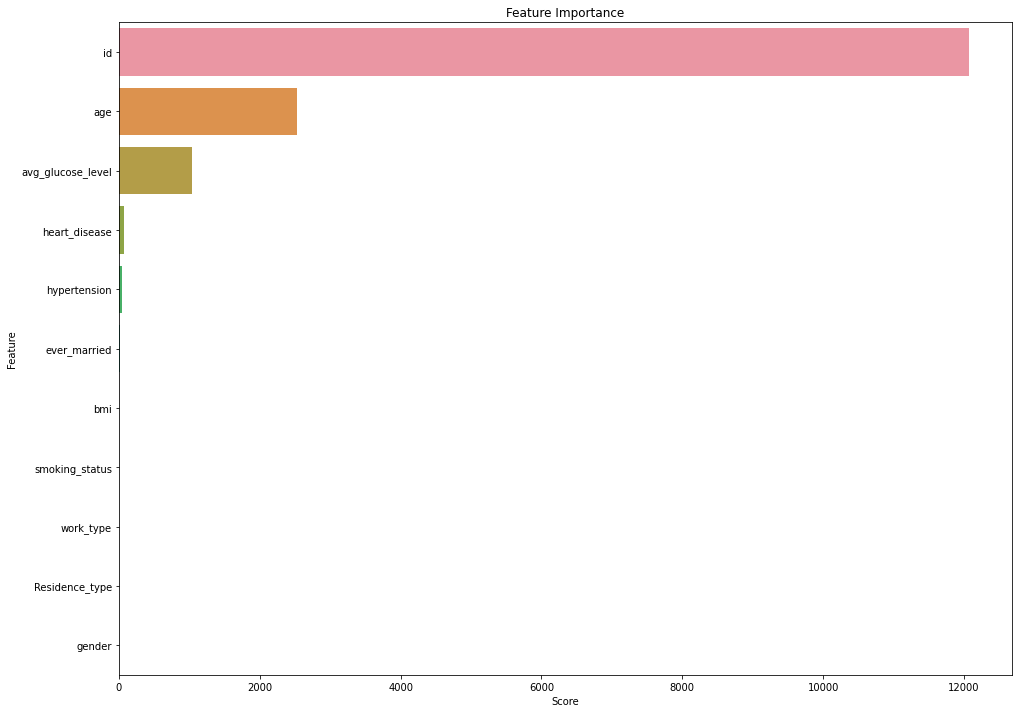

              Feature         Score
0                  id  12075.926720
2                 age   2532.074583
8   avg_glucose_level   1037.970541
4       heart_disease     67.819112
3        hypertension     46.700832
5        ever_married     15.498749
9                 bmi      7.169420
10     smoking_status      2.790695
6           work_type      2.172323
7      Residence_type      0.063106
1              gender      0.022248


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns

# Replace 'Yes'/'No' with 1/0 and encode other categorical variables
data['ever_married'] = data['ever_married'].replace({'Yes': 1, 'No': 0})
data['Residence_type'] = data['Residence_type'].replace({'Urban': 1, 'Rural': 0})

# Encoding remaining categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Defining features and target
features = data.drop(columns=['stroke']) # Assuming 'stroke' is your target column
target = data['stroke'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target, random_state=42)

# Remove features with low variance
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_high_variance = sel.fit_transform(X_train)

# Univariate feature selection
X_best_features = SelectKBest(score_func=chi2, k=10) # Adjust 'k' as necessary
X_best_features.fit_transform(X_train, y_train)

# Get score of each feature
feature_scores = X_best_features.scores_

# Get column names
columns = X_train.columns

# Create a dictionary and a dataframe with scores and features
feature_dict = dict(zip(columns, feature_scores))
feature_df = pd.DataFrame(feature_dict.items(), columns=['Feature', 'Score'])

# Sort the dataframe based on score
feature_df = feature_df.sort_values(by='Score', ascending=False)

# Plot the scores
plt.figure(figsize=(16,12))
sns.barplot(x='Score', y='Feature', data=feature_df)
plt.title('Feature Importance')
plt.show()

# Display the feature score dataframe
print(feature_df)

### Explanation

Before splitting the dataset into training and testing sets, we first encode all categorical columns using label encoding.

We create a dictionary to store each LabelEncoder instance for potential inverse transformations later.

We perform feature selection as before, but now without errors, since all columns are in a numerical format.

We replace 'Yes' with 1 and 'No' with 0 for the 'ever_married' column.

Similarly, we replace 'Urban' with 1 and 'Rural' with 0 for the 'Residence_type' column.

We then use label encoding for other categorical columns with string data types.

The remaining steps involved splitting the data, applying a variance threshold, and performing univariate feature selection to identify and plot the most important features.

<a id='section7'></a>
## Section 7: Implementing Decision Tree algorithm

Accuracy Score: 0.9021526418786693
Confusion Matrix:
[[1374   84]
 [  66    9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1458
           1       0.10      0.12      0.11        75

    accuracy                           0.90      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.91      0.90      0.91      1533



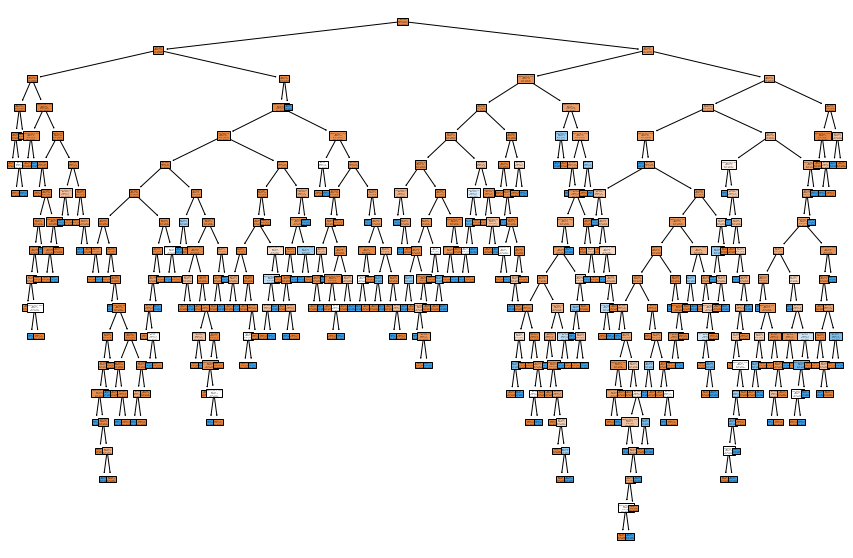

In [32]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Step 1: Initialize the DecisionTreeClassifier with default parameters
dt_classifier = DecisionTreeClassifier(random_state=42)

# Step 2: Fit the model to the training data
dt_classifier.fit(X_train, y_train)

# Step 3: Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Step 4: Evaluate the model's performance using accuracy score, confusion matrix, and classification report
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Step 5: Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, filled=True, feature_names=X_train.columns, class_names=['No Stroke', 'Stroke']) # Adjust class names as per your target variable categories
plt.show()

### Explanation:

The Decision Tree model learns the underlying patterns of the training dataset by optimizing the decision tree rules using the features (X_train) and the target variable (y_train).

After training on the training dataset, the model makes predictions on the unseen test dataset (X_test) and stores the predicted values in y_pred.

The model's performance is evaluated using various metrics:
Accuracy Score: This is the ratio of the number of correct predictions to the total number of predictions.

Confusion Matrix: It is a table that describes the performance of a classification model by presenting the true positives, false positives, true negatives, and false negatives.

Classification Report: This report contains the precision, recall, and F1-score which give a deeper understanding of the model's performance.


The Decision Tree diagram visualizes the various paths a data point takes through the decision tree, based on the features in the dataset. The tree splits the data into subsets based on the values of input features, and this process continues recursively, leading to a tree-like model of decisions.

In the visualization:

Root Node: This is the first node where the initial split of the dataset takes place. It is based on the feature that best separates the classes in your target variable.

Internal Nodes: These nodes represent the points where further splits in the data occur based on other features.

Leaves/ Terminal Nodes: These are the final nodes where no further splits occur. They represent the final predictions made by the tree.


The decision tree shows how the model decides on the class label (stroke or no stroke) for a data point based on the paths it follows from the root node down to a leaf node. It gives an in-depth view of the decision-making process of the model, displaying the criteria it uses at each step to make a split and showcasing the depth of the tree, which can give insights into the complexity of the model. It helps in understanding which features are more important in predicting the target variable and how different values of these features influence the prediction.

## <a id='section8'></a>
## Section 8: Optimization and Hyper-parameter Tuning

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
}

# Initialize a DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)

# Initialize a GridSearchCV object which will find the best hyper-parameters
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print('Best parameters found: ', grid_search.best_params_)

# Print the best cross-validation score
print('Best cross-validation score: {:.2f}'.format(grid_search.best_score_))

# Test the model on the test data
test_score = grid_search.score(X_test, y_test)
print('Test set score: {:.2f}'.format(test_score))

Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score: 0.95
Test set score: 0.95


### Aim
Hyper-parameter Tuning helps with optimizing the decision tree model by tuning hyper-parameters and will also help avoiding overfitting of the model

### Explanation: 

We imported the necessary libraries and modules for Decision Trees, hyperparameter tuning, and grid search.

We define a parameter grid (param_grid) that specifies the hyperparameters to search through. 

We initialize a DecisionTreeClassifier with a random state for reproducibility.

We create a GridSearchCV object (grid_search) that will perform the hyperparameter search with cross-validation. We specify the estimator (the decision tree classifier), the parameter grid, the number of cross-validation folds (cv), and the scoring metric ('accuracy' in this case).

We fit the grid_search object to the training data (X_train and y_train), which will perform the hyperparameter tuning.

We print out the best parameters found (best_params_), the best cross-validation score (best_score_), and the test set score to evaluate the model on the test data.